# Data Analysis of Misc Dataset

In [1]:
import sys
sys.path.append('../../../src')

import glob, os
import numpy as np 
import scipy as sp
import pandas as pd
from sklearn import decomposition, datasets, svm
from matplotlib import pyplot as plt
from p1.models.utils import get_common_label
from p1.models.utils import get_data_col, get_project_data, get_attr_nums
from p1.models.utils import creat_pred_file, calc_acc

%load_ext autoreload
%autoreload 2

## Data Loading

In [2]:
# Get Files
data_dir = "../project_data/data"
labels = ["guilty", "not guilty"]

(_, _, _, misc), Y = get_project_data(opts=[False, False, False, True])

## Experiments

In [3]:
misc_train, misc_eval, misc_test = (misc[i] for i in range(3))
Y_train, Y_eval, Y_test = (Y[i] for i in range(3))

### Data Visualization and Analysis

#### Dataset Attributes
**defendant_age**, 
**gender**, 
**num_victims**, 
**victim_genders**, 
**offence_category**, 
**offence_subcategory**

#### Defendent Age Attribute Analysis

Common label in training set:

In [82]:
print(f"Common label: {labels[int(get_common_label(Y_train)[0])]}. With occurance: {get_common_label(Y_train)[1]}")

Common label: not guilty. With occurance: 8789


Calculation of average suspect ages in training set.

In [45]:
# Calculate average age of suspects in training set. 
# Do not consider unknown ages (eg, 'not known' and 'shop-foreman').
ages = get_data_col(misc_train, "defendant_age")

t_len = len(ages)

known_ages_train = get_attr_nums(misc_train, attr_id="defendant_age", uk="not known")

avg_age = np.mean(known_ages_train[~np.isnan(known_ages_train)])
print(f"Average age of suspects in training set: {int(avg_age)} years old")
print(f"Average age of suspects in training set: {int(avg_age)} years old")

Average age of suspects in training set: 29 years old


Common labels of subset w/ and w/o unknown suspect ages.

In [47]:
y_k = Y_train[~np.isnan(known_ages_train)]; cl_k = get_common_label(y_k)
y_uk = Y_train[np.isnan(known_ages_train)]; cl_uk = get_common_label(y_uk)

print(f"Common label of subset with known suspect ages: {labels[int(cl_k[0])]}. With occurance: {cl_k[1]} / {len(y_k)}")
print(f"Common label of subset with unknown suspect ages: {labels[int(cl_uk[0])]}. With occurance: {cl_uk[1]} / {len(y_uk)}")

Common label of subset with known suspect ages: guilty. With occurance: 6387 / 7840
Common label of subset with unknown suspect ages: not guilty. With occurance: 7336 / 9660


* Discussion: From the results above on the training set, if a defendent's age is unknown, then they are likely not guilty. However, if the suspect's age is known then they are likely guilty.

Number of adults and children in subset containing known ages.

In [48]:
adult_mask = ~np.isnan(known_ages_train) & (known_ages_train >= 18)
y_a = Y_train[adult_mask]; cl_a = get_common_label(y_a)

ch_mask = ~np.isnan(known_ages_train) & (known_ages_train < 18)
y_c = Y_train[ch_mask]; cl_c = get_common_label(y_c)

print(f"Common label of subset with known adult suspects: {labels[int(cl_a[0])]}. With occurance: {cl_a[1]} / {len(y_a)}")
print(f"Common label of subset with known child suspects: {labels[int(cl_c[0])]}. With occurance: {cl_c[1]} / {len(y_c)}")

Common label of subset with known adult suspects: guilty. With occurance: 5554 / 6923
Common label of subset with known child suspects: guilty. With occurance: 833 / 917


* Discussion: For both identified adult and child defendants, cases rule 'guilty' in 80% of adult cases and 91% of child cases.

Visualization of known age subset. Points at y = 1.0 imply an adult suspect else a child suspect, where an adult is a person of age $\geq$ 18 years of age.

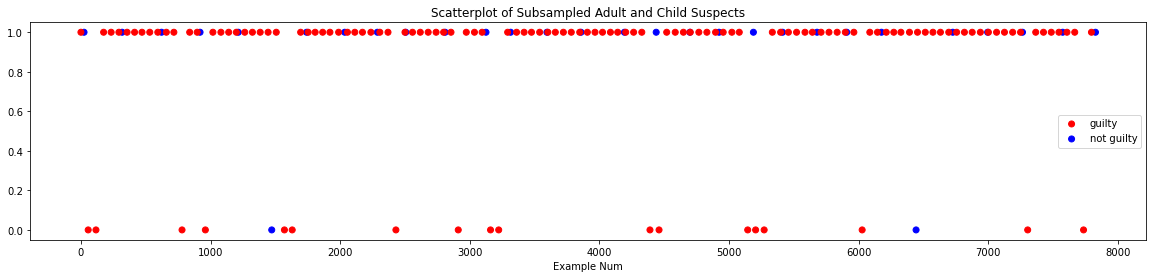

In [58]:
ka_subset = known_ages_train[~np.isnan(known_ages_train)]
colors = np.array(['b' if y_k[i] else 'r' for i in range(len(y_k))])
# colors_uk = ['b' if y_uk[i] else 'r' for i in range(len(y_uk))]

x = np.arange(len(y_k))

fig = plt.figure(figsize=[20, 4])
adult_age = 18

ng_mask = y_k == 1
ss = 50
ng = plt.scatter(x[ng_mask][::ss], (ka_subset >= adult_age)[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])
g_mask = y_k == 0
g = plt.scatter(x[g_mask][::ss], (ka_subset >= adult_age)[g_mask][::ss], \
                 color=colors[g_mask][::ss])
plt.legend((g, ng), labels)
plt.title("Scatterplot of Subsampled Adult and Child Suspects")
plt.xlabel("Example Num")
plt.show()

Visualization of training dataset by the defendant age attribute. 1.0 -> Known age, 0.0 -> Unknown age.

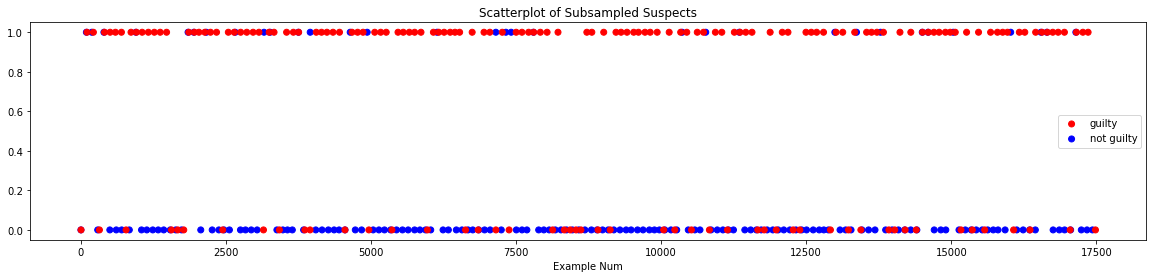

In [50]:
colors = np.array(['b' if y else 'r' for y in Y_train])

x = np.arange(len(Y_train))

fig = plt.figure(figsize=[20, 4])

ss = 50

k_mask = ~np.isnan(known_ages_train)
ng_mask = Y_train == 1
ng = plt.scatter(x[ng_mask][::ss], k_mask[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])

g_mask = Y_train == 0
g = plt.scatter(x[g_mask][::ss], k_mask[g_mask][::ss], \
                 color=colors[g_mask][::ss])

plt.legend((g, ng), labels)
plt.title("Scatterplot of Subsampled Suspects")
plt.xlabel("Example Num")
plt.show()

#### Defendent Gender Attribute Analysis

In [78]:
attr = "defendant_gender"
gends = get_data_col(misc_train, attr)

t_len = len(gends)

m_mask, f_mask = (gends == 'male').flatten(), (gends == 'female').flatten()
m, f = gends[m_mask], gends[f_mask]
print(f"Male Count: {len(m)}. Not guilty frequency: {len(Y_train[(Y_train==1.0) & m_mask])} / {len(m)}")
print(f"Female Count: {len(f)}. Not guilty frequency: {len(Y_train[(Y_train==1.0) & f_mask])} / {len(f)}")

Male Count: 13258. Not guilty frequency: 6349 / 13258
Female Count: 4236. Not guilty frequency: 2437 / 4236


* Discussion: It appears that a defendants gender does not have a significant effect on the outcomes of a court case aside from the higher frequency of identified male suspects.

#### Defendent Victim Count Attribute Analysis

In [87]:
attr = "num_victims"
vict_cnts = get_data_col(misc_train, attr)

t_len = len(vict_cnts)

print(f"Average victim counts on training dataset: {vict_cnts.mean()}")

ng_vict_cnts = vict_cnts[Y_train == 1.0]; g_vict_cnts = vict_cnts[Y_train == 0.0]
print(f"Average victim counts amongst non-guilty suspects: {ng_vict_cnts.mean()}")
print(f"Average victim counts amongst guilty suspects: {g_vict_cnts.mean()}")

Average victim counts on training dataset: 0.9767428571428571
Average victim counts amongst non-guilty suspects: 0.9553987939469791
Average victim counts amongst non-guilty suspects: 0.9982780392607049


* Discussion: It seems that victim count does not really affect guilty or non-guilty verdicts.

#### Feature Combinations

In [7]:
ages = get_attr_nums(misc_train, attr_id="defendant_age", uk="not known").flatten()
gends = get_data_col(misc_train, "defendant_gender"); gends = gends == "male"
vict_cnts = get_data_col(misc_train, "num_victims")

k_mask = ~np.isnan(ages)
colors = np.array(['b' if y else 'r' for y in Y_train])

x = np.arange(len(Y_train))

ng_mask = Y_train == 1
g_mask = Y_train == 0

ss = 50

Visualization of whether defendant's age is known and their gender. Male -> 1.0, Female -> 0.0

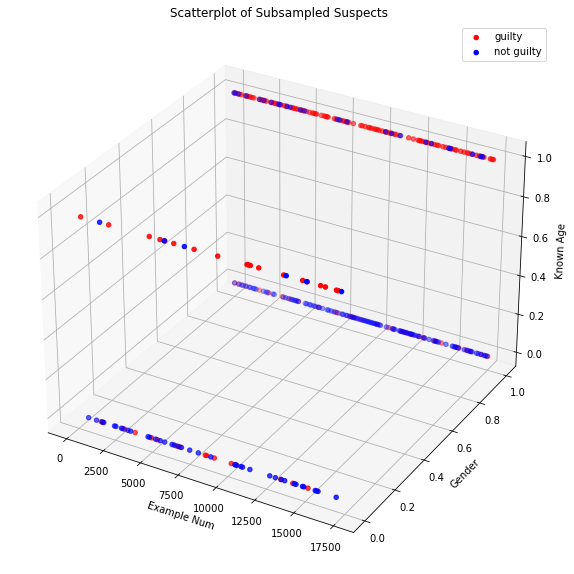

In [141]:
fig = plt.figure(figsize=[10, 10]); ax = plt.axes(projection='3d')

ng = ax.scatter3D(x[ng_mask][::ss], gends[ng_mask][::ss], k_mask[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])

g = ax.scatter3D(x[g_mask][::ss], gends[g_mask][::ss], k_mask[g_mask][::ss], \
                 color=colors[g_mask][::ss])

ax.legend((g, ng), labels)
ax.set_xlabel("Example Num"); ax.set_ylabel("Gender"); ax.set_zlabel("Known Age")

plt.title("Scatterplot of Subsampled Suspects")
plt.show()

Visualization of defendant age and gender.

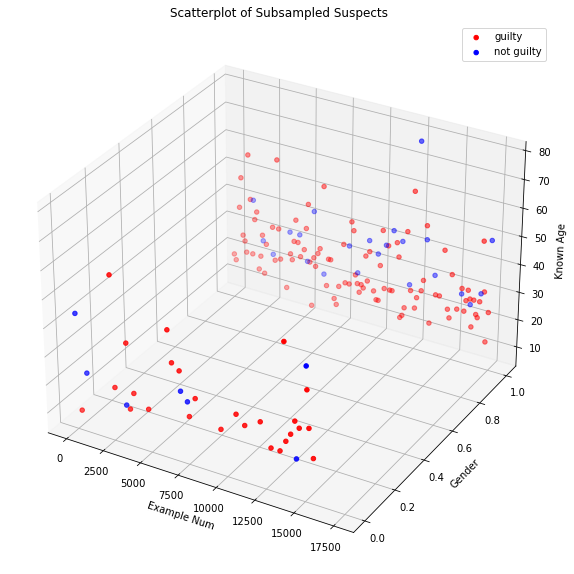

In [5]:
uk_mask = ~np.isnan(ages)

fig = plt.figure(figsize=[10, 10]); ax = plt.axes(projection='3d')

mask = (Y_train == 1) & uk_mask
ng = ax.scatter3D(x[mask][::ss], gends[mask][::ss], ages[mask][::ss], \
                 color=colors[mask][::ss])

mask = (Y_train == 0) & uk_mask
g = ax.scatter3D(x[mask][::ss], gends[mask][::ss], ages[mask][::ss], \
                 color=colors[mask][::ss])

ax.legend((g, ng), labels)
ax.set_xlabel("Example Num"); ax.set_ylabel("Gender"); ax.set_zlabel("Known Age")

plt.title("Scatterplot of Subsampled Suspects")
plt.show()

Visualization of whether a defendant's age is known and the number of victims in the case.

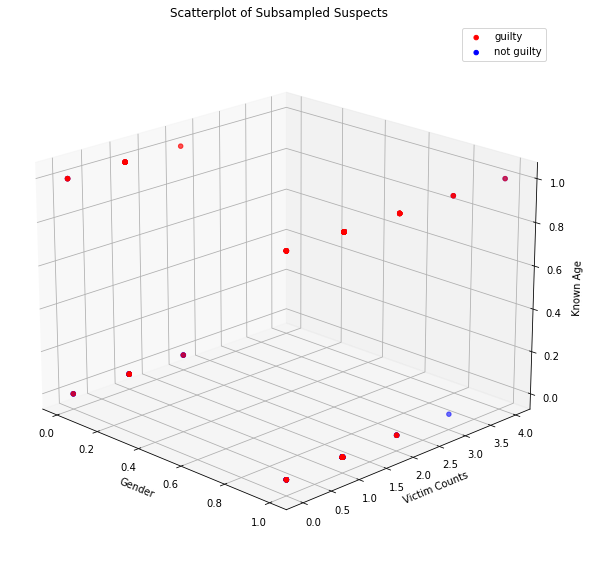

In [8]:
fig = plt.figure(figsize=[10, 10]); ax = plt.axes(projection='3d')

ng = ax.scatter3D(gends[ng_mask][::ss], vict_cnts[ng_mask][::ss], k_mask[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])

g = ax.scatter3D(gends[g_mask][::ss], vict_cnts[g_mask][::ss], k_mask[g_mask][::ss], \
                 color=colors[g_mask][::ss])

ax.legend((g, ng), labels)
ax.set_xlabel("Gender"); ax.set_ylabel("Victim Counts"); ax.set_zlabel("Known Age")
ax.view_init(20, -45)

plt.title("Scatterplot of Subsampled Suspects")
plt.show()

Consider a simple learner that classifies an example guilty if the age is known and not-guilty if the age is unknown.

In [ ]:
from p1.models.simple_learner import SL 

sl = SL()
print(f"Accuracy on training set: {calc_acc(sl.predict(known_ages_train), Y_train)}")

known_ages_test = get_attr_nums(misc_test, attr_id="defendant_age", uk="not known")
print(f"Accuracy on test set: {calc_acc(sl.predict(known_ages_test), Y_test)}")

Accuracy on training set: 0.7841714285714285
Accuracy on test set: 0.7888888888888889


* Discussion: As seen above the simple classifier is better than randomly guessing.

In [ ]:
# Generating a Kaggle submission.
known_ages_eval = get_attr_nums(misc_eval, attr_id="defendant_age", uk="not known")
sl_pred = sl.predict(known_ages_eval)

creat_pred_file(sl_pred, filename="final_sl_JL.csv")

SVM prediction on feature-set composed of // 